# BFast
A fast GPU based bispectrum estimator implemented with jax.

It contains a fast, more memory heavy algorithm, that can compute the bispectrum of 2276 triangle configurations in a 256^3 box in less than a second on a V100/A100, using float32 precision (~1.5x for float64).

There is also a slower, memory efficient algorithm for higher resolution grids or more bins. It computes the same 2276 triangle configurations in a 512^3 box in under 20 seconds on an A100, using float32 precision (~1.5x for float64).

Requirements:
- numpy
- jax
- jax-tqdm
- matplotlib (for example notebook)

Installation: clone the repository and cd into the directory then install using 'pip install .' (optionally add the -e flag to install in developer mode)

# Demonstration

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import BFast
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
jax.device_count()

1

In [2]:
BoxSize = 1000.
kF = 2*np.pi/BoxSize
grid = 256

In [3]:
df = np.load(f"df_m_256_PCS_z=0.npy")
df.dtype

dtype('float32')

In [4]:
help(BFast.Bk)

Help on function Bk in module BFast.BFast:

Bk(delta, BoxSize, fc, dk, Nbins, triangle_type='All', open_triangles=True, MAS=None, fast=True, precision='float32', file_path='./', verbose=False)
    Computes binned bispectrum of field for given binning and triangles
    
    Parameters:
    -----------
    delta: array
        Real field to compute bispectrum of
    BoxSize:
        Size of box in comoving units (Mpc/h) such that power spectrum has units (Mpc/h)^3 and bispectrum has units (Mpc/h)^6
    fc: float
        Center of first bin in units of the fundamental mode.
    dk: float
        Width of the bin in units of the fundamental mode.
    Nbins: int
        Total number of momentum bins such that bins are given by [(fc + i)±dk/2 for i in range(Nbins)].
    triangle_type: str, optional (default='All')
        Type of triangles to include in the bispectrum calculation. 
        Options: 'All' (include all shapes of triangles),
                 'Squeezed' (include only triangles k

In [5]:
%time Bks_32 = BFast.Bk(df,BoxSize,3.,3.,27,'All',MAS='PCS',fast=True,precision='float32',verbose=True)
%time Bks_64 = BFast.Bk(df,BoxSize,3.,3.,27,'All',MAS='PCS',fast=True,precision='float64',verbose=True)

No counts file found, computing this first!
Considering 2276 Triangle Configurations (All), with kmax = 0.5184
Saved Triangle Counts to ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
CPU times: user 2.94 s, sys: 744 ms, total: 3.68 s
Wall time: 5.62 s
No counts file found, computing this first!
Considering 2276 Triangle Configurations (All), with kmax = 0.5184
Saved Triangle Counts to ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat64.npy
CPU times: user 2.67 s, sys: 784 ms, total: 3.46 s
Wall time: 5.3 s


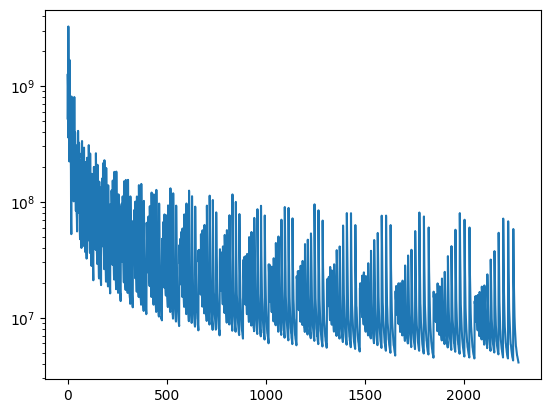

In [6]:
plt.semilogy(Bks_32[:,-2])

## The first time jax compiles certain parts and compute triangle counts, a next call is blazing fast:

In [7]:
%time Bks_32 = BFast.Bk(df,BoxSize,3.,3.,27,'All',MAS='PCS',fast=True,precision='float32',verbose=False)
%time Bks_64 = BFast.Bk(df,BoxSize,3.,3.,27,'All',MAS='PCS',fast=True,precision='float64',verbose=False)

Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184
CPU times: user 420 ms, sys: 175 ms, total: 594 ms
Wall time: 526 ms
Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat64.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184
CPU times: user 579 ms, sys: 305 ms, total: 884 ms
Wall time: 819 ms


## Float32 precision is very accurate but faster:

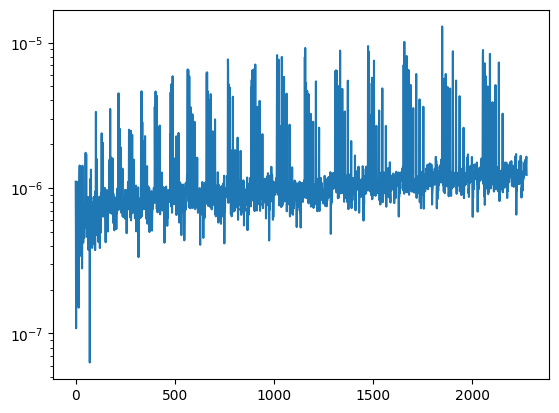

In [8]:
plt.semilogy(np.abs((Bks_32[:,-2]-Bks_64[:,-2])/Bks_64[:,-2]))

## There is also a slower but more memory friendly algorithm for larger boxes or more bins

In [9]:
%time Bks_32_slow = BFast.Bk(df,BoxSize,3.,3.,27,'All',MAS='PCS',fast=False,precision='float32',verbose=False)
%time Bks_64_slow = BFast.Bk(df,BoxSize,3.,3.,27,'All',MAS='PCS',fast=False,precision='float64',verbose=False)

Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

CPU times: user 4.21 s, sys: 125 ms, total: 4.33 s
Wall time: 5.25 s
Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat64.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

CPU times: user 6.13 s, sys: 112 ms, total: 6.24 s
Wall time: 7.26 s


## Again, Float32 precision is very accurate but faster:

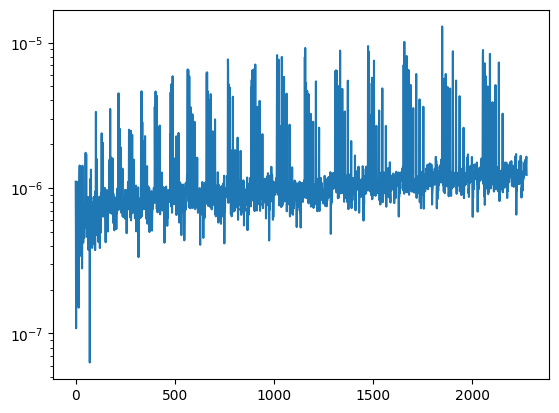

In [10]:
plt.semilogy(np.abs((Bks_32_slow[:,-2]-Bks_64_slow[:,-2])/Bks_64_slow[:,-2]))

## There is also a power spectrum method with a binning of kF:

In [11]:
help(BFast.Pk)

Help on function Pk in module BFast.BFast:

Pk(delta, BoxSize, MAS=None, left_inclusive=True, precision='float32')
    Computes binned powerspectrum of field
    
    Parameters:
    -----------
    delta: array
        Real field to compute powerspectrum of
    BoxSize:
        Size of box in comoving units (Mpc/h) such that power spectrum has units (Mpc/h)^3
    MAS: str, optional (default=None)
        Mass Assignment Scheme window function to compensate for (options are NGP,CIC,TSC,PCS)
    left_inclusive: bool, optional (default=True)
        If True, uses left-inclusive bins. If False, uses right-inclusive bins instead.
    
    Returns:
    --------
    result: numpy.ndarray
        An array of shape (Nbins,3) containing the power spectrum and related information.
        The columns contain: {mean k of the bin, P(k), number of modes in bin}



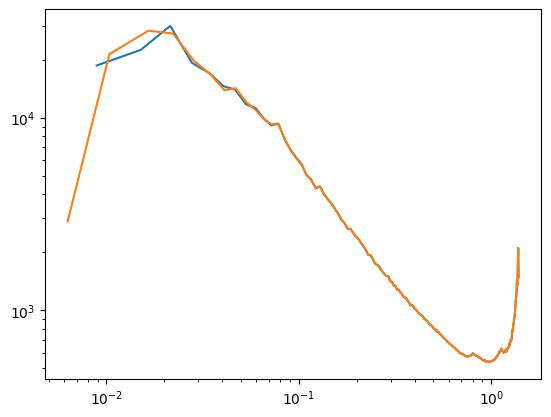

In [12]:
Pks_32_left = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=True,precision='float32')
Pks_32_right = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=False,precision='float32')
Pks_64_left = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=True,precision='float64')
Pks_64_right = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=False,precision='float64')

plt.loglog(Pks_32_left[:,0],Pks_32_left[:,1])
plt.loglog(Pks_32_right[:,0],Pks_32_right[:,1])

In [13]:
%time Pks_32_left = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=True,precision='float32')
%time Pks_32_right = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=False,precision='float32')
%time Pks_64_left = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=True,precision='float64')
%time Pks_64_right = BFast.Pk(df,1000.,MAS='PCS',left_inclusive=False,precision='float64')

CPU times: user 379 ms, sys: 8.6 ms, total: 387 ms
Wall time: 306 ms
CPU times: user 365 ms, sys: 9.97 ms, total: 375 ms
Wall time: 309 ms
CPU times: user 333 ms, sys: 31.6 ms, total: 364 ms
Wall time: 323 ms
CPU times: user 329 ms, sys: 29 ms, total: 358 ms
Wall time: 317 ms


## Float32 precision is very accurate, but the speed up is minimal in this case (at this grid size!)

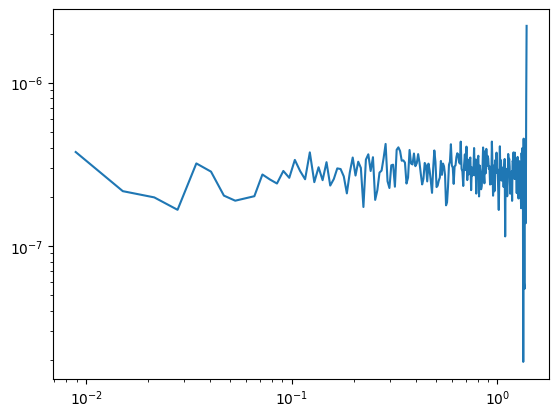

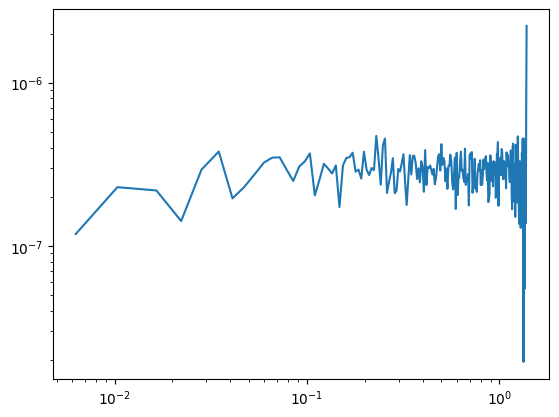

In [14]:
plt.loglog(Pks_64_left[:,0],np.abs((Pks_32_left[:,-2]-Pks_64_left[:,-2])/Pks_64_left[:,-2]))
plt.show()
plt.loglog(Pks_64_right[:,0],np.abs((Pks_32_right[:,-2]-Pks_64_right[:,-2])/Pks_64_right[:,-2]))
plt.show()

## Finally, there is also a cross powerspectrum:

In [15]:
%time Px = BFast.xPk(df,df**2.,1000.,MAS=['PCS','PCS'])

CPU times: user 705 ms, sys: 29.6 ms, total: 735 ms
Wall time: 1.14 s


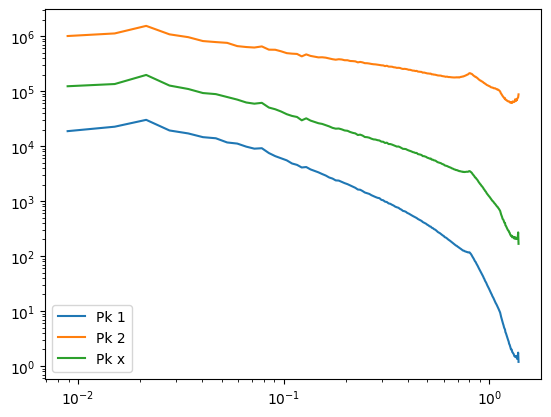

In [16]:
plt.loglog(Px[:,0],Px[:,1],label='Pk 1')
plt.loglog(Px[:,0],Px[:,2],label='Pk 2')
plt.loglog(Px[:,0],Px[:,3],label='Pk x')
plt.legend()
plt.show()

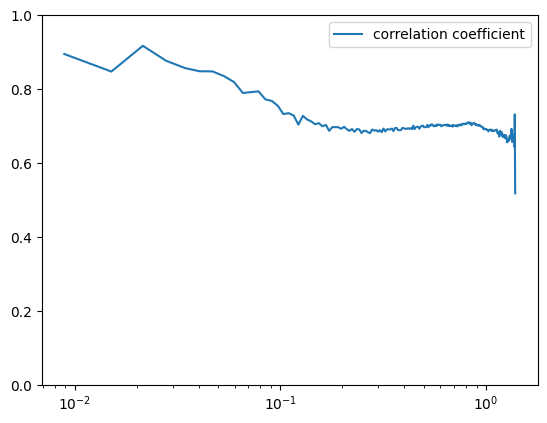

In [17]:
plt.semilogx(Px[:,0],Px[:,4],label="correlation coefficient")
plt.ylim(0,1)
plt.legend()
plt.show()